In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.stats import expon

import pandas as pd

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 18

from scipy.optimize import curve_fit


In [3]:
def autocorrelation(series,from_mean=True):
    """Compute the normalized autocorrelation function of a time series."""
    if from_mean:
        series = np.array(series) - np.mean(series)  # Remove mean
    else:
        series = np.array(series)
    n = len(series)
    norm = np.var(series) * n  # Normalization factor
    result = np.correlate(series, series, mode="full") / norm  # Compute autocorrelation
    return result[n-1:] / result[n-1:][0]

In [4]:
def projection(x,y,vx,vy):
    r = np.sqrt(x**2 + y**2)
    v = np.sqrt(vx**2 + vy**2)

    # Avoid division by zero
    r[r == 0] = np.nan
    v[v == 0] = np.nan

    # Compute projection
    projection = (x * vx + y * vy) / (r * v)
    projection[np.isnan(projection)] = 0
    
    
    return projection

def crossings(projection,t):
    sign_changes = np.where(np.sign(projection[:-1]) != np.sign(projection[1:]))[0]

    # Extract times at which the sign changes
    t_crossings = t[sign_changes]

    # Compute time intervals between consecutive crossings
    time_intervals = np.diff(t_crossings)
    return time_intervals


def displacement(x,y,step):
    dx = x[step:] - x[:-step]  # Difference in x
    dy = y[step:] - y[:-step]  # Difference in y

    displacements = np.sqrt(dx**2 + dy**2)
    
    return displacements

In [5]:
def find_zero_crossing_lag(acf):
    """Find the first zero crossing lag of the autocorrelation function."""
    indices = np.where(np.sign(acf[:-1]) != np.sign(acf[1:]))[0]
    return indices[0] + 1 if len(indices) > 0 else None


In [6]:
def mov_not_mov(A,th,zero_th=False):
    """
    Calculate moving and non moving steps.
    
    Parameters
    -----------
    A = array with the values to be analyzed, it can be the smoothed speed or the speed 
    
    th = threshold (taken from the prob of moving and prob of not moving)
    
    Return
    -------
    
    tuple: 
    
    (ns,ms,signal) = (list with NOT moving steps, list with MOVING steps,binary signal (+1 if this step and the next is above threshold, 0 if below))
     
    """
    
    # mask is an array that in each element has True if the value of array A is less than the threshold
    if zero_th:
        mask = A > th
        signal = [] # binary signal
        n=0 # counter for non moving steps
        m=0 # counter for moving steps
        ns=[] # list with consecutive non moving steps
        ms = [] # list with consecutive moving steps
        
        for i in range(len(A)-1):
            
            if mask[i] == False and mask[i+1] == False: # if this value in A and the next are below the threshold
                
                # print('n=',n)
                if m!=0: # append the current running value of m if we changed from moving to non moving
                    
                    ms.append(m)
                m=0 # reset the counter for moving steps
                signal.append(0) # append 0 to the signal
                n+=1 # begin counting non moving steps
            elif mask[i] == True or mask[i+1] == True: 
                # same as before but with the opposite condition
                if n!=0:
                    
                    ns.append(n)
                n=0
                signal.append(1)
                m+=1
            if i+1 == len(A)-1: 
                # if we are in the last element of A, we append the last values of n,m and the signal
                if mask[i] == False or mask[i+1] == False:
                    signal.append(0)
                    ns.append(n)
                else:
                    signal.append(1)
                    ns.append(m)
    else:
        mask = A <= th
        
        signal = [] # binary signal
        n=0 # counter for non moving steps
        m=0 # counter for moving steps
        ns=[] # list with consecutive non moving steps
        ms = [] # list with consecutive moving steps
        
        for i in range(len(A)-1):
            
            if mask[i] == True and mask[i+1] == True: # if this value in A and the next are below the threshold
                
                # print('n=',n)
                if m!=0: # append the current running value of m if we changed from moving to non moving
                    
                    ms.append(m)
                m=0 # reset the counter for moving steps
                signal.append(0) # append 0 to the signal
                n+=1 # begin counting non moving steps
            elif mask[i] == False or mask[i+1] == False: 
                # same as before but with the opposite condition
                if n!=0:
                    
                    ns.append(n)
                n=0
                signal.append(1)
                m+=1
            if i+1 == len(A)-1: 
                # if we are in the last element of A, we append the last values of n,m and the signal
                if mask[i] == False or mask[i+1] == False:
                    signal.append(1)
                    ms.append(m)
                else:
                    signal.append(0)
                    ns.append(n)

    return ns,ms,signal,mask
            

# All trajectories

In [16]:

def persistence_intervals(x, y, vx, vy, t,if_plot=False,title1=None,title2=None,title3=None):
    """
    Compute displacements and time intervals between consecutive sign changes
    of the projection of position onto velocity direction.
    
    Parameters
    ----------
    x, y : array-like
        Position components.
    vx, vy : array-like
        Velocity components.
    t : array-like
        Time array corresponding to positions and velocities.
    
    Returns
    -------
    results : dict
        {
            'displacements': array of displacements between sign changes,
            'time_intervals': array of time intervals between sign changes,
            'mean_displacement': float,
            'mean_time_interval': float
        }
    """
    x = np.asarray(x)
    y = np.asarray(y)
    vx = np.asarray(vx)
    vy = np.asarray(vy)
    t = np.asarray(t)
    
    # Compute projection of position onto velocity direction
    r = np.sqrt(x**2 + y**2)
    v = np.sqrt(vx**2 + vy**2)
    proj = (x*vx + y*vy) / (r * v)
    
    # Find sign changes
    sign = np.sign(proj)
    # avoid zero by treating zero as previous sign
    zero_mask = sign == 0
    sign[zero_mask] = np.sign(proj[np.where(zero_mask)[0] - 1])
    change_idx = np.where(sign[:-1] != sign[1:])[0] + 1
    
    # Times at sign changes
    t_changes = t[change_idx]
    time_intervals = np.diff(t_changes)
    
    # Positions at sign changes
    pos = np.vstack((x, y)).T
    disp = np.linalg.norm(pos[change_idx[1:]] - pos[change_idx[:-1]], axis=1)
    
    # Plot distributions
    if if_plot:
        plt.figure(figsize=(8,4),layout='tight')
        plt.subplot(1,2,1)
        plt.hist(disp, bins=30, density=True, alpha=0.7)
        plt.xlabel("Displacement\nbetween sign changes")
        plt.ylabel("Probability Density")
        if title1:
            plt.title(title1,fontsize=15)
       
        
        plt.subplot(1,2,2)
        plt.hist(time_intervals, bins=30, density=True, alpha=0.7)
        plt.xlabel("Time interval\nbetween sign changes")
        plt.ylabel("Probability Density")
        if title2:
            plt.title(title2,fontsize=15)
        if title3:
            plt.suptitle(title3,fontsize=15,y=0.9)
        plt.show()
    
    return {
        'displacements': disp,
        'time_intervals': time_intervals,
        'mean_displacement': np.mean(disp),
        'mean_time_interval': np.mean(time_intervals)
    }

In [20]:
videos = [2,3,4]

all_displacements = []
all_time_intervals = []



for video in videos: 
    
    name = f'data/new-videos/video{video}/video{video}_wspeedsmooth.csv'
    df = pd.read_csv(name,index_col=0)
  
    ids = df['Track ID'].unique()
  
    for id in ids[:]:
        traj = df[df['Track ID'] == id].sort_values('Frame')
        time = traj['Frame'].values
        x,y = traj['x (micron)'].values,traj['y (micron)'].values
        vx,vy = traj['vx'].values,traj['vy'].values
        results = persistence_intervals(x,y,vx,vy,time,if_plot=False,title3=f'id = {id}')
        all_displacements+=list(results['displacements'])
        all_time_intervals += list(results['time_intervals'])
        

/tmp/ipykernel_79462/583697008.py:34: RuntimeWarning: invalid value encountered in divide
  proj = (x*vx + y*vy) / (r * v)
/tmp/ipykernel_79462/583697008.py:34: RuntimeWarning: invalid value encountered in divide
  proj = (x*vx + y*vy) / (r * v)
/tmp/ipykernel_79462/583697008.py:34: RuntimeWarning: invalid value encountered in divide
  proj = (x*vx + y*vy) / (r * v)


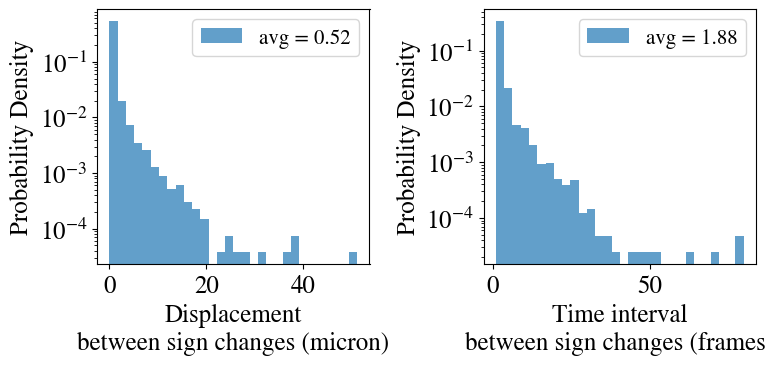

In [26]:
plt.figure(figsize=(8,4),layout='tight')
plt.subplot(1,2,1)
plt.hist(all_displacements, bins=30, density=True, alpha=0.7,label=f'avg = {np.mean(all_displacements):.2f}')
plt.xlabel("Displacement\nbetween sign changes (micron)")
plt.ylabel("Probability Density")
plt.legend(fontsize=15)
plt.semilogy()

plt.subplot(1,2,2)
plt.hist(all_time_intervals, bins=30, density=True, alpha=0.7,label=f'avg = {np.mean(all_time_intervals):.2f}')
plt.xlabel("Time interval\nbetween sign changes (frames)")
plt.ylabel("Probability Density")
plt.legend(fontsize=15)
plt.semilogy()
plt.show()

In [27]:
dataframe_isolated = pd.read_csv('data/group-trajectories/second_wave/isolated_pairs_video1_v3_wspeeds.csv',index_col = 0)
ids_isolated = dataframe_isolated['Track ID'].unique()
computed_ids_isolated = []
for id in ids_isolated: 
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    if traj['Info'].values[0] == "Isolated" and id != 16:
        computed_ids_isolated.append(id)

/tmp/ipykernel_79462/583697008.py:34: RuntimeWarning: invalid value encountered in divide
  proj = (x*vx + y*vy) / (r * v)


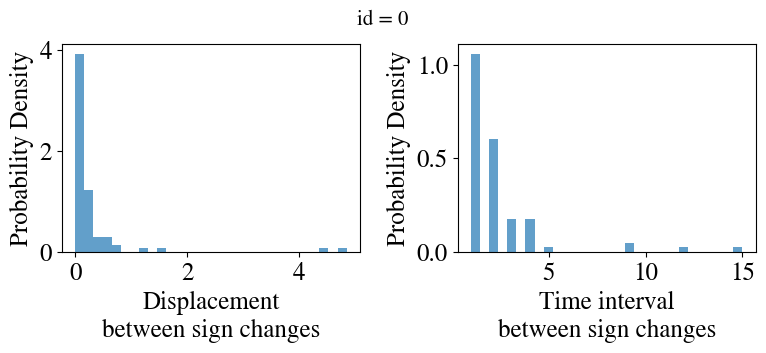

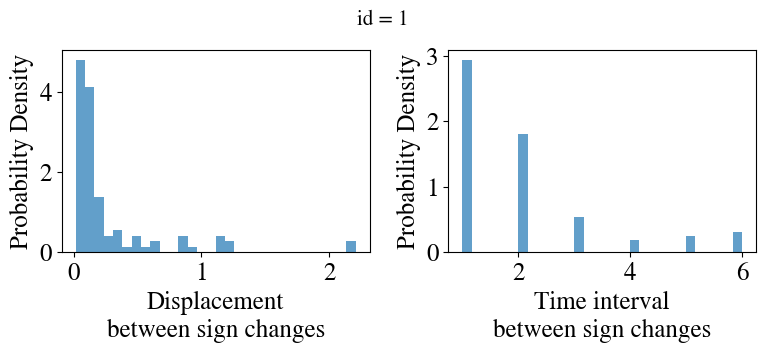

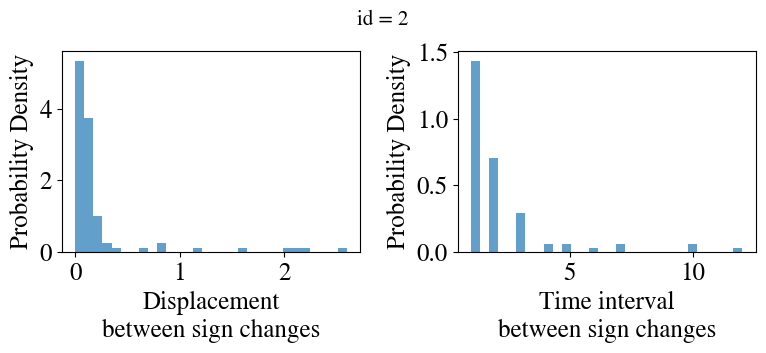

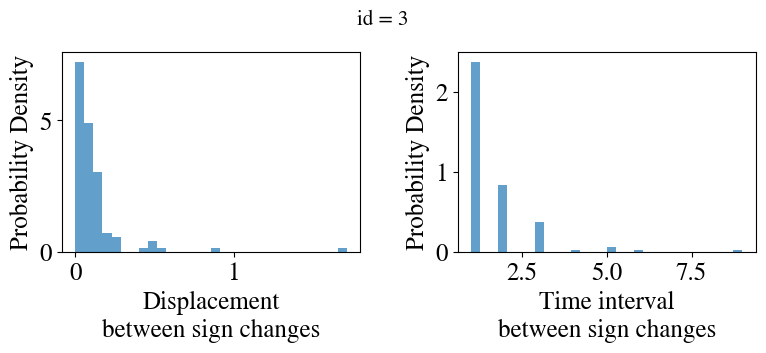

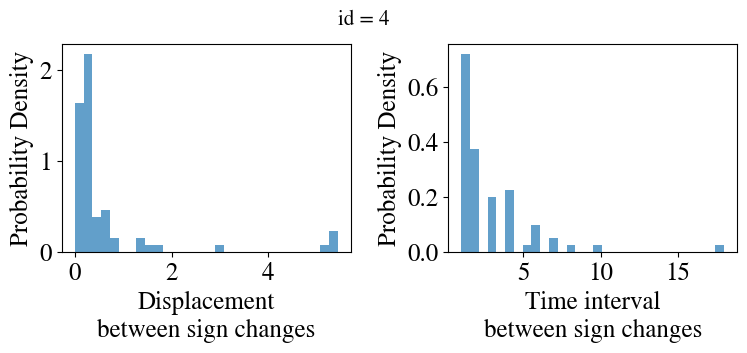

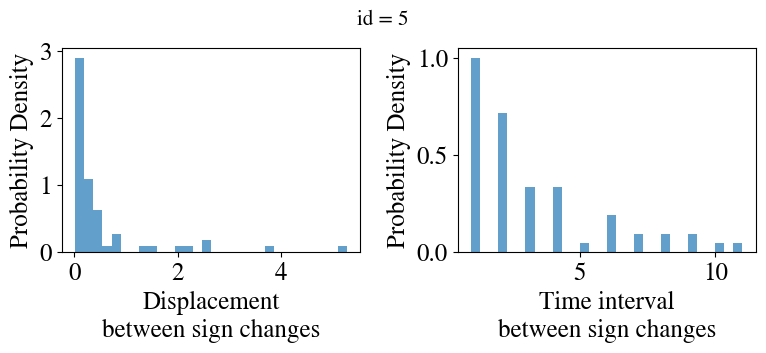

In [28]:

all_displacements_isolated = []
all_time_intervals_isolated = []

for id in computed_ids_isolated: 
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    # print(f'id = {id}')
    # if traj['Info'].values[0] == "Isolated" and id != 16:
    
    time = traj['Frame'].values
    x,y = traj['x (micron)'].values,traj['y (micron)'].values
    vx,vy = traj['vx'].values,traj['vy'].values
    results = persistence_intervals(x,y,vx,vy,time,if_plot=True,title3=f'id = {id}')
    all_displacements_isolated+=list(results['displacements'])
    all_time_intervals_isolated += list(results['time_intervals'])

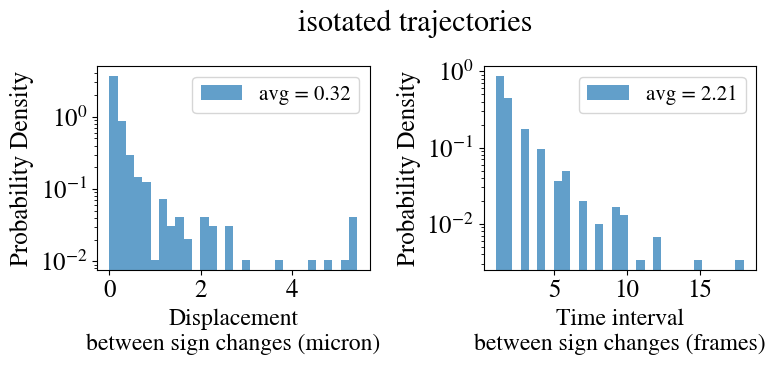

In [40]:
plt.figure(figsize=(8,4),layout='tight')
plt.subplot(1,2,1)
plt.hist(all_displacements_isolated, bins=30, density=True, alpha=0.7,label=f'avg = {np.mean(all_displacements_isolated):.2f}')
plt.xlabel("Displacement\nbetween sign changes (micron)",fontsize=17)
plt.ylabel("Probability Density")
plt.legend(fontsize=15)
plt.semilogy()

plt.subplot(1,2,2)
plt.hist(all_time_intervals_isolated, bins=30, density=True, alpha=0.7,label=f'avg = {np.mean(all_time_intervals_isolated):.2f}')
plt.xlabel("Time interval\nbetween sign changes (frames)",fontsize=17)
plt.ylabel("Probability Density")
plt.legend(fontsize=15)
plt.semilogy()
plt.suptitle('isotated trajectories',y=0.93,x=0.54)
plt.show()